# Segmented regressions with exponential sampling and heteroscedastic noise

In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
import random
import matplotlib.pyplot as plt
import numpy

print(__version__)
print(__git_version__)

0.0.6
daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [2]:
min_x = 1
max_x = 1e9
nb_breakpoints = 6
size = 1000
numpy.random.seed(27)
#breakpoints = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), nb_breakpoints))))
breakpoints = [10**n for n in range(1, 9)]
print(f'Breakpoints: {breakpoints}')
x_list = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), size))))
interval_idx = 0
y_list = []
tmp_break = breakpoints + [numpy.inf]
for i, x in enumerate(x_list):
    if x > tmp_break[interval_idx]:
        interval_idx += 1
    assert x <= tmp_break[interval_idx]
    slope = interval_idx
    intercept = (interval_idx+1)*10
    y_list.append(x*slope + intercept)
dataset = list(zip(x_list, y_list))

Breakpoints: [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]


In [3]:
sigma = 0.1
noisy_dataset = [(x, y+numpy.random.normal(scale=sigma)*x) for x, y in dataset]
x = [t[0] for t in noisy_dataset] 
x = numpy.array(x)
y = [t[1] for t in noisy_dataset] 
y = numpy.array(y)

## Top-down

Here, this is the usual stuff, we add breakpoints using a tree-like approach.

9
x ≤ 9.860e+07?
    └──x ≤ 9.806e+06?
    │    └──x ≤ 9.923e+05?
    │    │    └──x ≤ 9.907e+04?
    │    │    │    └──x ≤ 9.728e+03?
    │    │    │    │    └──x ≤ 9.936e+02?
    │    │    │    │    │    └──x ≤ 9.850e+01?
    │    │    │    │    │    │    └──x ≤ 9.989e+00?
    │    │    │    │    │    │    │    └──y ~ -2.468e-02x + 1.000e+01
    │    │    │    │    │    │    │    └──y ~ 9.854e-01x + 2.065e+01
    │    │    │    │    │    │    └──y ~ 1.978e+00x + 3.843e+01
    │    │    │    │    │    └──y ~ 2.982e+00x + 1.255e+02
    │    │    │    │    └──x ≤ 9.322e+04?
    │    │    │    │         └──y ~ 4.028e+00x + -7.364e+02
    │    │    │    │         └──y ~ -3.286e+02x + 3.293e+07
    │    │    │    └──y ~ 5.068e+00x + -1.494e+04
    │    │    └──y ~ 5.991e+00x + 7.143e+04
    │    └──y ~ 6.961e+00x + 1.086e+06
    └──y ~ 8.015e+00x + -2.623e+06


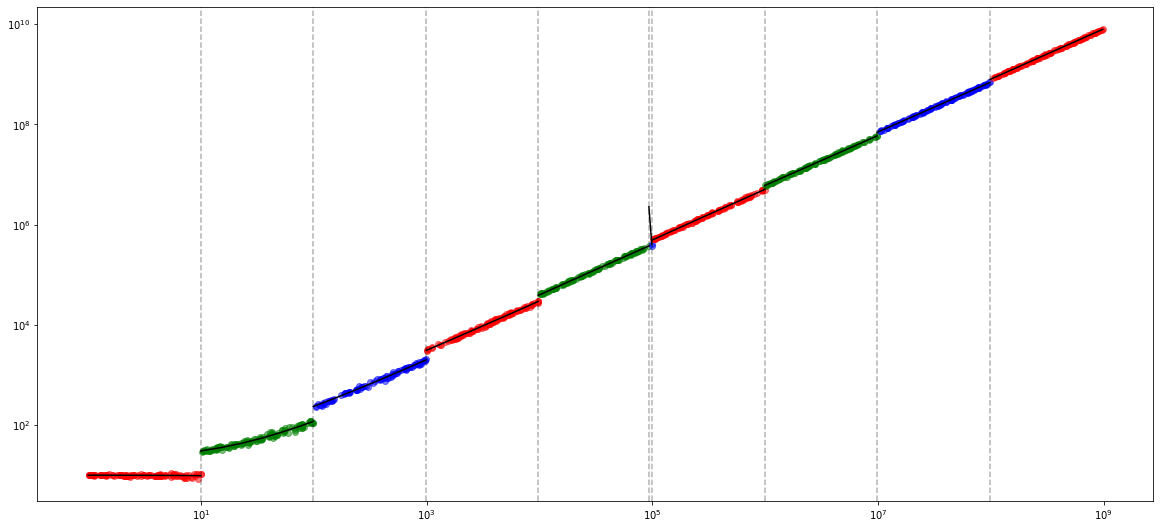

In [4]:
reg = compute_regression(x, y)
print(len(reg.breakpoints))
print(reg)
reg.plot_dataset(log=True)

## Bottom-up (classical)

Here we remove breakpoints greedily, using the BIC.

In [5]:
reg.simplify()

,regression,RSS,BIC,AIC,BIClog,RSSlog,nb_breakpoints
0,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33181.092504,32989.690048,1.413798e+03,1.144395,9
1,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33153.461483,32981.690048,2.154600e+04,21.304230,8
2,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33125.830462,32973.690048,inf,inf,7
3,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33098.199441,32965.690048,inf,inf,6
4,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33070.568422,32957.690051,inf,inf,5
5,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33042.937411,32949.690061,inf,inf,4
6,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965015e+17,33015.307411,32941.691082,inf,inf,3
7,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965185e+17,32987.762782,32933.777474,inf,inf,2
8,"((1.0090191751595254, 10.01196389068455), (1.0...",1.983058e+17,32969.185726,32934.831439,inf,inf,1
9,"((1.0090191751595254, 10.01196389068455), (1.0...",4.481227e+17,33756.811437,33742.088171,inf,inf,0


-inf < x ≤ 9.860e+07
	y ~ 6.983e+00x + -5.247e+05
9.860e+07 < x ≤ inf
	y ~ 8.015e+00x + -2.623e+06


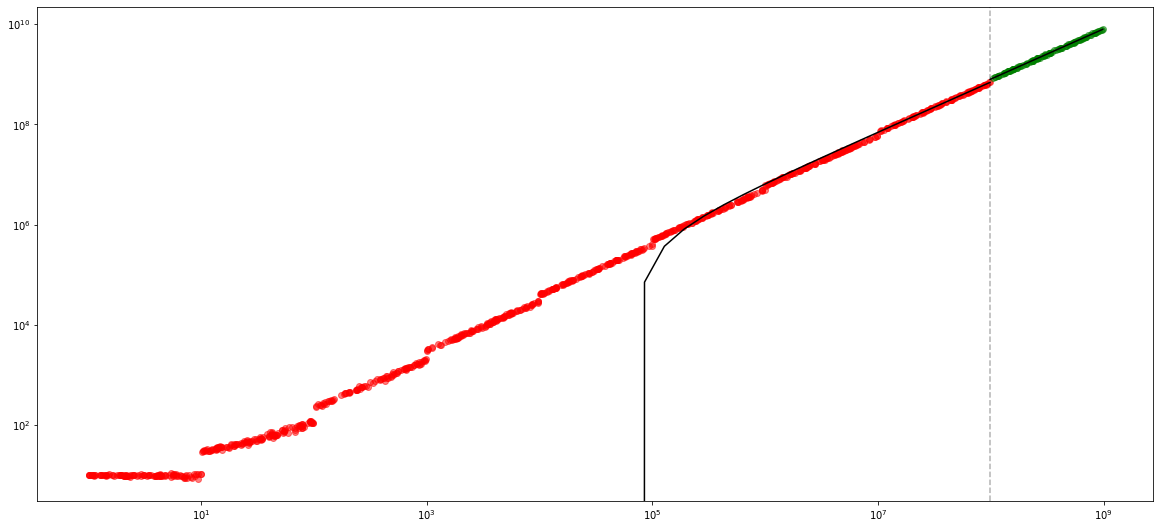

In [6]:
auto_simple = reg.auto_simplify()
print(auto_simple)
auto_simple.plot_dataset(log=True)

## Bottom-up (log)

Same algorithm as above, we remove breakpoints, but this time we changed the formula for the error.

Now, we define (with $N$ the number of points and $P$ the number of model parameters):

$$\text{RSSlog} = \sum_i \left(\log(y_i) - \log(\alpha x_i + \beta)\right)^2$$

$$\text{BIClog} = P\log(N) + N \text{RSSlog}$$

In the following simplification, we minimize this BIClog value instead of minimizing the BIC value.

In [7]:
reg.simplify(RSSlog=True)

,regression,RSS,BIC,AIC,BIClog,RSSlog,nb_breakpoints
0,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33181.092504,32989.690048,1.413798e+03,1.144395,9
1,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965013e+17,33153.461486,32981.690051,1.389814e+03,1.148042,8
2,"((1.0090191751595254, 10.01196389068455), (1.0...",1.976106e+17,33131.459802,32979.319388,2.878050e+03,2.663909,7
3,"((1.0090191751595254, 10.01196389068455), (1.0...",1.976107e+17,33103.829255,32971.319862,1.333668e+04,13.150174,6
4,"((1.0090191751595254, 10.01196389068455), (1.0...",1.976107e+17,33076.198234,32963.319862,3.346889e+04,33.310009,5
5,"((1.0090191751595254, 10.01196389068455), (1.0...",1.976107e+17,33048.567213,32955.319862,5.489499e+04,54.763739,4
6,"((104.14948708841223, 244.59078516871426), (10...",1.978098e+17,33021.943508,32948.327179,inf,inf,3
7,"((10161.83639743402, 42051.66257510043), (1028...",1.978211e+17,32994.369328,32940.384020,inf,inf,2
8,"((1007568.6848391223, 6062856.568297457), (101...",1.979491e+17,32967.385160,32933.030874,inf,inf,1
9,"((103905035.92819102, 837906135.4177926), (109...",4.481227e+17,33756.811437,33742.088171,inf,inf,0


-inf < x ≤ 9.989e+00
	y ~ -2.468e-02x + 1.000e+01
9.989e+00 < x ≤ 9.850e+01
	y ~ 9.854e-01x + 2.065e+01
9.850e+01 < x ≤ 9.936e+02
	y ~ 1.978e+00x + 3.843e+01
9.936e+02 < x ≤ 9.728e+03
	y ~ 2.982e+00x + 1.255e+02
9.728e+03 < x ≤ 9.907e+04
	y ~ 4.008e+00x + -1.754e+02
9.907e+04 < x ≤ 9.923e+05
	y ~ 5.068e+00x + -1.494e+04
9.923e+05 < x ≤ 9.806e+06
	y ~ 5.991e+00x + 7.143e+04
9.806e+06 < x ≤ 9.860e+07
	y ~ 6.961e+00x + 1.086e+06
9.860e+07 < x ≤ inf
	y ~ 8.015e+00x + -2.623e+06


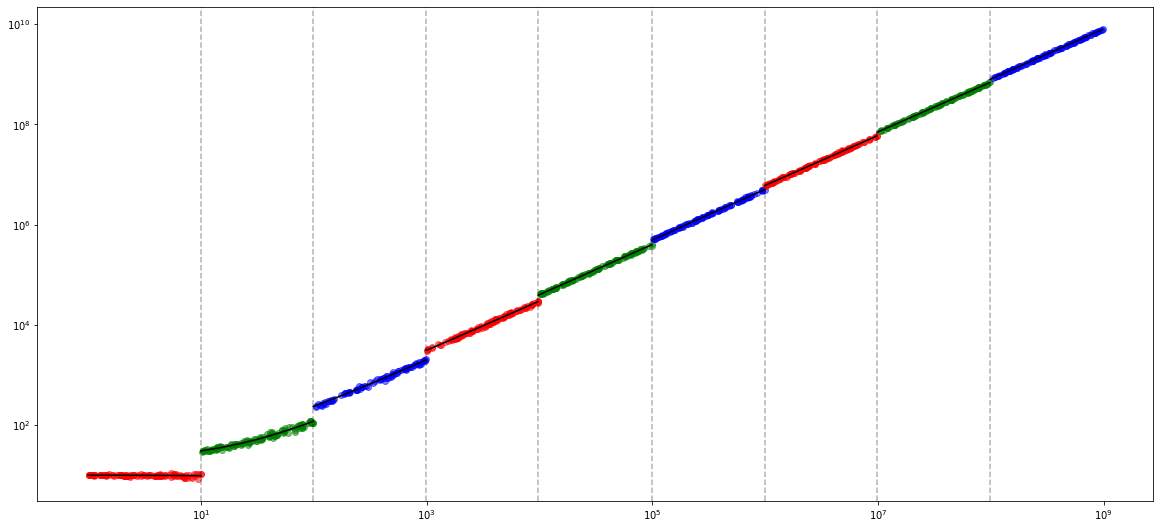

In [8]:
auto_simple = reg.auto_simplify(RSSlog=True)
print(auto_simple)
auto_simple.plot_dataset(log=True)

In [9]:
import pandas
segments = []
for i, seg in enumerate(auto_simple.segments):
    segments.append({
        'min_x': seg[0][0],
        'max_x': seg[0][1],
        'RSS': seg[1].RSS,
        'RSSlog': seg[1].compute_RSSlog()
    })
pandas.DataFrame(segments)

,min_x,max_x,RSS,RSSlog
0,-inf,9.989428e+00,1.799220e+01,0.189108
1,9.989428e+00,9.850368e+01,2.430442e+03,0.481454
2,9.850368e+01,9.936408e+02,1.734526e+05,0.190818
3,9.936408e+02,9.727959e+03,2.415735e+07,0.134513
4,9.727959e+03,9.907217e+04,2.302752e+09,0.052518
5,9.907217e+04,9.923422e+05,2.430035e+11,0.039676
6,9.923422e+05,9.806350e+06,1.835682e+13,0.027400
7,9.806350e+06,9.860397e+07,2.679466e+15,0.016717
8,9.860397e+07,inf,1.938032e+17,0.015838
